Autor: Peter J Usherwood

In [1]:
import pandas as pd
import csv
import numpy as np
import itertools

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# Descrição do Problema

Este é um problema de "supervised learning" significando que nós temos um alvo que nós precisamos prever usando as outras características. Este documento está separado dentro duas partes. Primeiro vamos explorar e pré-processar o conjunto de dados. Segundo vamos criar os conjuntos de treino e teste, tentar varios classificadores, escolhar e provar o melhor, olhar para as carateristicas mais importas, e finalmente dar algumas intuições.

In [2]:
df = pd.read_csv('problem1_dataset.csv')
print(len(df))

180275


# 1. Explorando e Pré-Processando as Características

In [3]:
len(df.columns)

21

Há 21 colunas nos conjuntos de dados, dessas duas são IDs (ITEM_ID e SESSION_ID) e uma é o nosso alvo (INTERESTED). Se nós removermos estas duas colunas nós temos 18 caraterísticas que nós podemos usar para prever o alvo. Primeiro nós vamos explorar os dados, se uma caraterística não tem muitos registros ou não tem uma boa correlação com o alvo então talvez ela não daria bons resultados criando um modelo de previsão.

In [4]:
df.ix[:5,6:]

,LARGURA,MARCA,PARA_LAVA_LOUCAS,PARA_MICRO_ONDAS,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_FERRO_FUNDIDO,TEM_GRELHA,TEM_TAMPA,TIPO_PRODUTO,TIPO_WOK,SESSION_ID,ITEM_PRICE,INTERESTED
0,14.0,LA CUISINE,NaN,NaN,NaN,50.0,3.0,NAO,SIM,1.0,PANELA,NAO,86.709770,199.990000,0.0
1,24.0,TRAMONTINA,No,no,150.0,40.0,12.0,NAO,NAO,1.0,PIPOQUEIRA,NAO,73.156401,105.112581,0.0
2,20.0,LA CUISINE,Yes,no,190.0,20.0,3.0,NAO,NAO,1.0,ESPAGUETEIRA,NAO,952.331024,139.990000,0.0
3,41.5,TRAMONTINA,Yes,NaN,120.0,47.0,NaN,NAO,NAO,1.0,PIPOQUEIRA,NAO,637.759106,103.293333,1.0
4,41.5,TRAMONTINA,Yes,NaN,120.0,47.0,NaN,NAO,NAO,1.0,PIPOQUEIRA,NAO,478.531428,103.330242,0.0
5,14.0,LA CUISINE,NaN,NaN,NaN,50.0,3.0,NAO,SIM,1.0,PANELA,NAO,914.936724,179.990000,0.0


# 1.1 Limpar as Características

# Limpar e Agrupar

Primeiro nós precisamos limpar os dados, e ao mesmo tempo, vai ajudar a agrupar as caraterísticas com o mesmo tipo porque nós não podemos comparar dados binários com dados categóricos.

In [5]:
# continuo

con_cols = ['ALTURA', 'CAPACIDADE_(L)', 'LARGURA', 'PESO', 'PROFUNDIDADE', 'TEMPO_GARANTIA', 'ITEM_PRICE']

df.ix[:5, con_cols]

,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE,TEMPO_GARANTIA,ITEM_PRICE
0,30.5,NaN,14.0,NaN,50.0,3.0,199.990000
1,22.0,NaN,24.0,150.0,40.0,12.0,105.112581
2,24.0,NaN,20.0,190.0,20.0,3.0,139.990000
3,49.5,6.0,41.5,120.0,47.0,NaN,103.293333
4,49.5,6.0,41.5,120.0,47.0,NaN,103.330242
5,30.5,NaN,14.0,NaN,50.0,3.0,179.990000


In [6]:
# binario

bin_cols = ['PARA_LAVA_LOUCAS', 'PARA_MICRO_ONDAS', 'TEM_GRELHA', 'TEM_FERRO_FUNDIDO', 'TEM_TAMPA', 'TIPO_WOK']

df.ix[:5, bin_cols]

,PARA_LAVA_LOUCAS,PARA_MICRO_ONDAS,TEM_GRELHA,TEM_FERRO_FUNDIDO,TEM_TAMPA,TIPO_WOK
0,NaN,NaN,SIM,NAO,1.0,NAO
1,No,no,NAO,NAO,1.0,NAO
2,Yes,no,NAO,NAO,1.0,NAO
3,Yes,NaN,NAO,NAO,1.0,NAO
4,Yes,NaN,NAO,NAO,1.0,NAO
5,NaN,NaN,SIM,NAO,1.0,NAO


In [7]:
# categorico

cat_cols = ['COMPOSICAO', 'COR', 'FORMATO', 'MARCA', 'TIPO_PRODUTO']

df.ix[:5, cat_cols]

,COMPOSICAO,COR,FORMATO,MARCA,TIPO_PRODUTO
0,ALUMINIO,VINHO,NaN,LA CUISINE,PANELA
1,ALUMINIO,COLORIDO,NaN,TRAMONTINA,PIPOQUEIRA
2,INOX,INOX,NaN,LA CUISINE,ESPAGUETEIRA
3,ALUMINIO,VERMELHO,REDONDO,TRAMONTINA,PIPOQUEIRA
4,ALUMINIO,VERMELHO,REDONDO,TRAMONTINA,PIPOQUEIRA
5,ALUMINIO,VINHO,NaN,LA CUISINE,PANELA


# 1.1.1 Contínuo

# 1.1.1.1 Limpar Outliers e Valores Impossíveis

In [8]:
df[con_cols].describe()

,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE,TEMPO_GARANTIA,ITEM_PRICE
count,171007.000000,76671.000000,171007.000000,98524.000000,171007.000000,122770.000000,167178.000000
mean,30.575636,4.234668,27.882157,311.259118,34.797386,13.870742,127.831019
std,14.856403,1.699274,10.494943,1727.585999,15.179911,43.641581,137.298241
min,2.000000,0.045000,4.500000,0.619000,2.500000,1.000000,0.550000
25%,19.000000,3.100000,20.000000,120.000000,19.800000,3.000000,74.990000
50%,30.500000,4.500000,27.800000,160.000000,38.500000,6.000000,104.482418
75%,42.700000,6.000000,35.000000,190.000000,47.000000,12.000000,146.327727
max,84.000000,11.000000,91.000000,44400.000000,148.000000,300.000000,2274.990000


Primeiro nós podemos ver que as colunas ALTURA, CAPACIDADE_(L), LARGURA, e PROFUNDIDADE tem valores que fazem sentido, não há valores impossíveis (por exemplo uma capacidade negativa), e também não existem valores que parecem errados (por exemplo uma profundidade de 10000000), assim nós podemos presumir que todos os valores presentes são bons.

Para as outras colunas (PESO, TEMPO_GARANTIA, e ITEM_PRICE) todos os valores são possíveis, mas os máximos e mínimos (menos o mínimo de TEMPO_GARANTIA) poderiam estar errados, eles são mais de 10x as quartis, vamos olhar pra ver se esses valores são únicos e assim talvez um erro, ou so parte de uma coleção de produtos que são diferentes para a média.

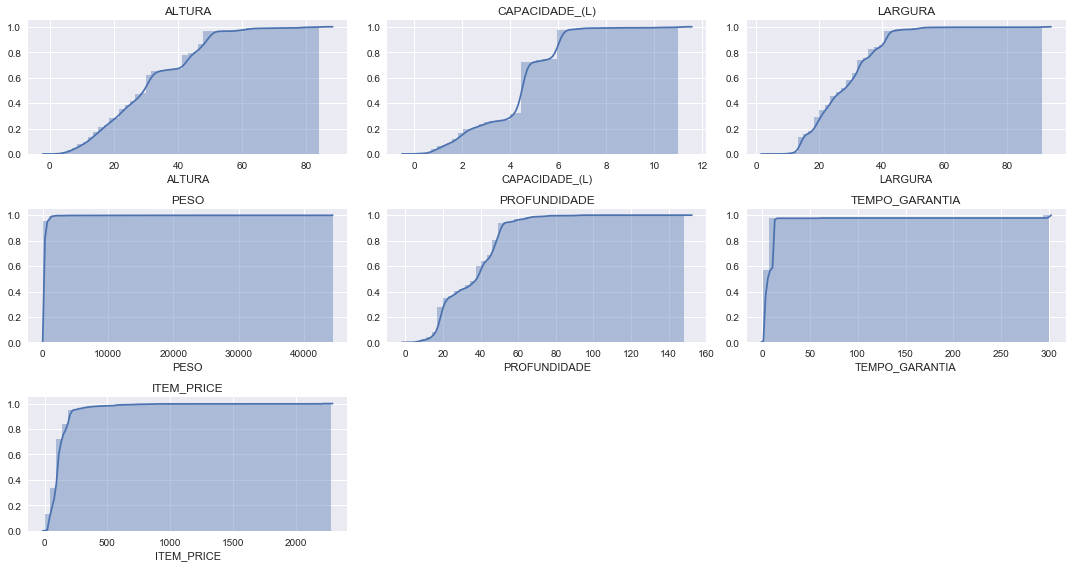

In [9]:
fig = plt.figure(figsize=(15,8))

axs = []
for i, col in enumerate(con_cols):
    axs.append(fig.add_subplot(3,3,i+1))
    axs[i].set_title(col)
    sns.distplot(df[~df[col].isnull()][col],
                 ax=axs[i],
                 hist_kws=dict(cumulative=True),
                 kde_kws=dict(cumulative=True))
    plt.tight_layout()

In [10]:
# Peso

df[~df['PESO'].isnull()]['PESO'].sort_values(ascending=False)[200:210]

8028      13130.0
167510    13130.0
101748    13130.0
25418     13130.0
16139     13130.0
6292      13130.0
13710     13130.0
27307     13130.0
118140     4800.0
123741     4800.0
Name: PESO, dtype: float64

In [11]:
# Tempo Garantia

df[~df['TEMPO_GARANTIA'].isnull()]['TEMPO_GARANTIA'].sort_values(ascending=False)[200:210]

71374     300.0
134865    300.0
34945     300.0
157999    300.0
175927    300.0
134793    300.0
134794    300.0
158005    300.0
60924     300.0
158011    300.0
Name: TEMPO_GARANTIA, dtype: float64

In [12]:
# Item Price

df[~df['ITEM_PRICE'].isnull()]['ITEM_PRICE'].sort_values(ascending=False)[200:210]

72646     2209.99
144508    2209.99
36367     2209.99
34278     2209.99
73917     2209.99
36413     2209.99
148260    2209.99
56115     2209.99
19839     2209.99
148341    2209.99
Name: ITEM_PRICE, dtype: float64

Vamos ver em cima que todos os outliers estão em grupos de pelo menos 200 registros, isso é pequeno comparado com o tamanho do conjunto de dados mas é improvável que eles estejam errados e talvez eles tenham informações importantes assim por agora vamos deixar tudo dentro o conjunto (mas talvez vamos precisar remover mais tarde).

Agora só precisamos remover os NaNs.

# 1.1.1.2 Limpar Dados Faltantes

Para dados contínuos nós podemos substituir os dados falantes com a média

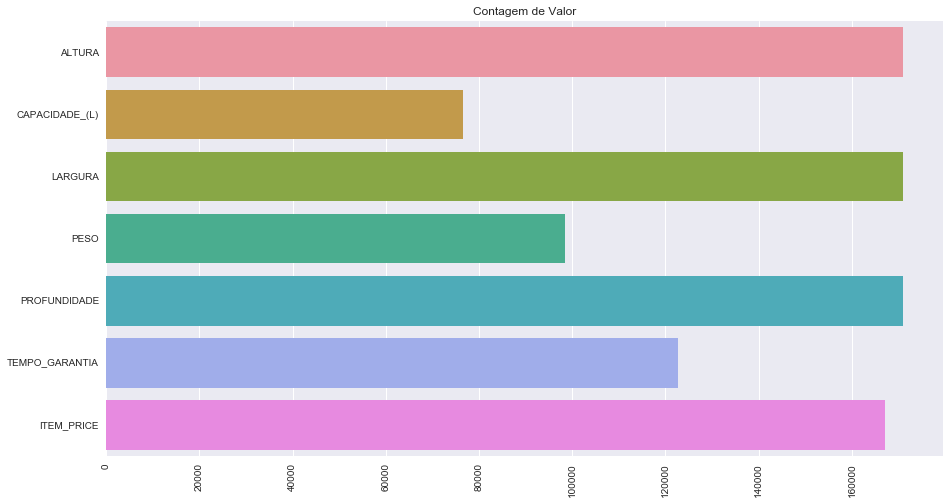

In [13]:
f, axarray = plt.subplots(1,1,figsize=(15,8))
plt.xticks(rotation = 'vertical')
axarray.set_title('Contagem de Valor')

bins = df[con_cols].count()

sns.barplot(ax=axarray,
            x=bins.values,
            y=bins.index,
            orient='h')

In [14]:
for col in con_cols:
    df[col] = df[col].fillna(df[col].mean())
    
df[con_cols].describe()

,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE,TEMPO_GARANTIA,ITEM_PRICE
count,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000
mean,30.575636,4.234668,27.882157,311.259118,34.797386,13.870742,127.831019
std,14.469476,1.108178,10.221607,1277.150101,14.784558,36.014575,132.216815
min,2.000000,0.045000,4.500000,0.619000,2.500000,1.000000,0.550000
25%,19.600000,4.234668,20.000000,160.000000,19.800000,3.000000,81.311401
50%,30.500000,4.234668,27.882157,311.259118,36.500000,12.000000,107.107222
75%,42.700000,4.500000,32.700000,311.259118,47.000000,13.870742,139.900000
max,84.000000,11.000000,91.000000,44400.000000,148.000000,300.000000,2274.990000


# 1.1.2 Binário

# 1.1.2.1 Limpar 

Primeiro vamos limpar os dados assim todas as caraterísticas tem valores 1 ou 0. Fazemos 1 e 0 porque é mais fácil para usar que TRUE e FALSE

In [15]:
for col in bin_cols:
    print(col)
    df[col] = df[col].replace('Yes', 1).replace('yes', 1).replace('SIM', 1)
    df[col] = df[col].replace('No', 0).replace('no', 0).replace('NAO', 0)
    print(df[col].value_counts())

PARA_LAVA_LOUCAS
1.0    74615
0.0    29471
Name: PARA_LAVA_LOUCAS, dtype: int64
PARA_MICRO_ONDAS
0.0    81367
1.0     5035
Name: PARA_MICRO_ONDAS, dtype: int64
TEM_GRELHA
0    160090
1     20185
Name: TEM_GRELHA, dtype: int64
TEM_FERRO_FUNDIDO
0    154938
1     25337
Name: TEM_FERRO_FUNDIDO, dtype: int64
TEM_TAMPA
0.0    100827
1.0     79448
Name: TEM_TAMPA, dtype: int64
TIPO_WOK
0    144820
1     35455
Name: TIPO_WOK, dtype: int64


# 1.1.2.2 Limpar Dados Faltantes

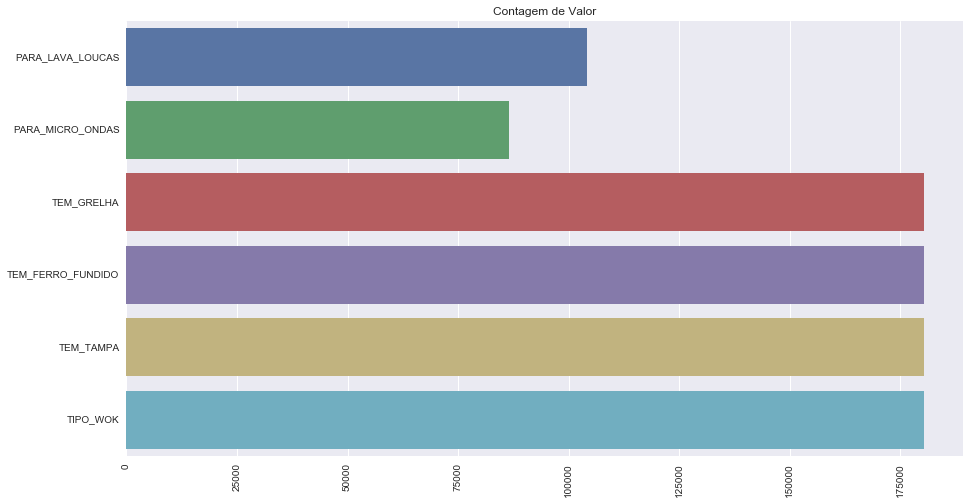

In [16]:
f, axarray = plt.subplots(1,1,figsize=(15,8))
plt.xticks(rotation = 'vertical')
axarray.set_title('Contagem de Valor')

bins = df[bin_cols].count()

sns.barplot(ax=axarray,
            x=bins.values,
            y=bins.index,
            orient='h')

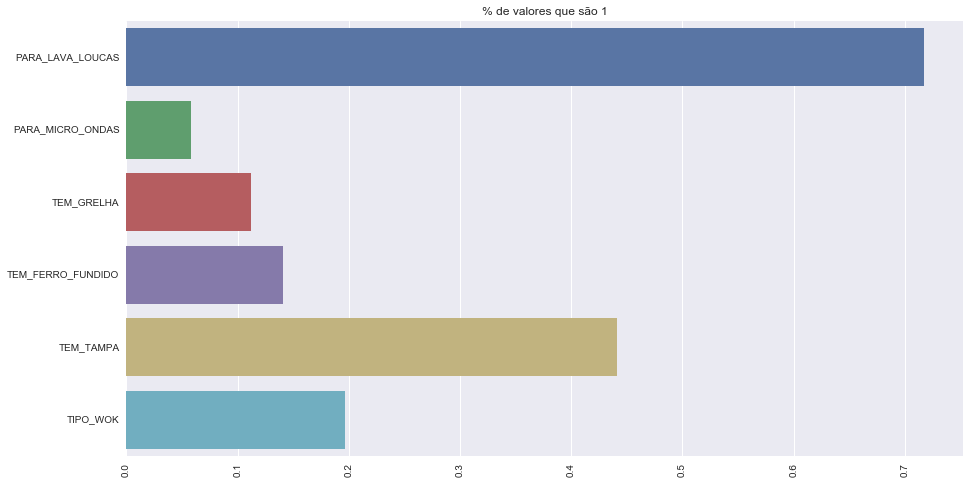

In [17]:
f,axarray = plt.subplots(1,1,figsize=(15,8))
plt.xticks(rotation = 'vertical')
axarray.set_title('% de valores que são 1')

bins = df[bin_cols].sum()/df[bin_cols].count()

sns.barplot(ax=axarray,
            x=bins.values,
            y=bins.index,
            orient='h')

As coisas interessantes aqui são PARA_LAVA_LOUCAS e PARA_MICRO_ONDAS, ambos têm valores perdidos, mas porque ambos tem uma preferência nos valores (PARA_LAVA_LOUCAS é 72% 1s e PARA_MICRO_ONDAS é 94% 0s) nós podemos substituir os NaNs com os modos. Isso é bom porque nós não podemos trabalhar com valores perdidos mas não queremos remover tantos (100K) registros.

In [18]:
df['PARA_LAVA_LOUCAS'].fillna(1, inplace=True)
df['PARA_MICRO_ONDAS'].fillna(0, inplace=True)

df[bin_cols].describe()

,PARA_LAVA_LOUCAS,PARA_MICRO_ONDAS,TEM_GRELHA,TEM_FERRO_FUNDIDO,TEM_TAMPA,TIPO_WOK
count,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000
mean,0.836522,0.027930,0.111968,0.140546,0.440704,0.196672
std,0.369802,0.164771,0.315328,0.347554,0.496473,0.397483
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 1.1.3 Categórico

# 1.1.3.1 Agrupar valores

In [19]:
df[cat_cols].describe()

,COMPOSICAO,COR,FORMATO,MARCA,TIPO_PRODUTO
count,156978,170251,90011,180001,180275
unique,5,24,5,35,38
top,ALUMINIO,INOX,REDONDO,TRAMONTINA,PANELA
freq,114218,34502,79888,72971,62418


Precisamos olhar mais para cada categoria para ver se eles têm valores com pequenas quantidades de valores. Se sim é melhor para agrupar esses dentro grupos maiores (vamos tentar pelo menos 1%) porque nós não queremos over-fit para os valores pequenos. Para agrupar nós temos duas opções:

1. Vamos tentar agrupar os pequenos com valores que já existem se o grupo faria sentido usando o nosso conhecimento de dominio (por exemplo, se uma marca pequena é uma sub-marca de uma outra marca então nós podemos agrupar)
2. Se nós não podemos fazer a opção 1, vamos agrupar bastante os pequenos valores dentro de um grupo chamado "Outro"

In [20]:
df[cat_cols[0]].value_counts()/df[cat_cols[0]].value_counts().sum()

ALUMINIO         0.727605
INOX             0.258374
CERAMICA         0.012307
PORCELANA        0.000885
ACO ESMALTADO    0.000828
Name: COMPOSICAO, dtype: float64

Aqui vamos agrupar os últimos três dentro um grupo chamado "outros", este grupo faz sentido porque nós não podemos agrupar tudo com uma outra categoria, mas também estes valores têm propriedades similares.

In [21]:
df[cat_cols[0]] = df[cat_cols[0]].replace('CERAMICA', 'OUTROS').replace('PORCELANA', 'OUTROS').replace('ACO ESMALTADO', 'OUTROS')
df[cat_cols[0]].value_counts()/df[cat_cols[0]].value_counts().sum()

ALUMINIO    0.727605
INOX        0.258374
OUTROS      0.014021
Name: COMPOSICAO, dtype: float64

In [22]:
df[cat_cols[1]].value_counts()/df[cat_cols[1]].value_counts().sum()

INOX         0.202654
PRETO        0.180956
VERMELHO     0.179000
CEREJA       0.139089
COLORIDO     0.051048
GRAFITE      0.046708
VINHO        0.037621
GOIABA       0.030766
AMARELO      0.025509
PRATA        0.022156
LARANJA      0.013944
COBRE        0.013451
BERINGELA    0.010749
AZUL         0.010432
VERDE        0.007824
CHOCOLATE    0.006919
TURQUESA     0.006461
ROXO         0.004905
MARROM       0.004846
BRANCO       0.002261
ROSA         0.001821
CINZA        0.000717
FENDI        0.000141
ACACIA       0.000023
Name: COR, dtype: float64

Podemos agrupar as cores dentro de grupos de cores mais simples, este processo é subjetivo e deve ser feito idealmente com o cliente usando os dados. Achamos FENDI que não é uma cor assim nós vamos remover agora como um erro.

In [23]:
colour_map = {'INOX':'PRATA',
              'PRETO':'PRETO_E_BRANCO',
              'VERMELHO':'VERMELHO',
              'CEREJA':'VERMELHO',
              'COLORIDO':'COLORIDO',
              'GRAFITE':'CINZA',
              'VINHO':'ROXA',
              'GOIABA':'ROXA',
              'AMARELO':'AMARELO',
              'PRATA':'PRATA',
              'LARANJA':'LARANJA',
              'COBRE':'MARROM',
              'BERINGELA':'ROXA',
              'AZUL':'AZUL',
              'VERDE':'VERDE',
              'CHOCOLATE':'MARROM',
              'TURQUESA':'VERDE',
              'ROXO':'ROXA',
              'MARROM':'MARROM',
              'BRANCO':'PRETO_E_BRANCO',
              'ROSA':'ROXA',
              'CINZA':'CINZA',
              'FENDI':None,
              'ACACIA':'AMARELO'}

for val in df[cat_cols[1]].value_counts().index.tolist():
    if val is not 'FENDI':
        df[cat_cols[1]] = df[cat_cols[1]].replace(val, colour_map[val])
    
df[cat_cols[1]].value_counts()/df[cat_cols[1]].value_counts().sum()

VERMELHO          0.318115
PRATA             0.224846
PRETO_E_BRANCO    0.183248
ROXA              0.085874
COLORIDO          0.051066
CINZA             0.047436
AMARELO           0.025533
MARROM            0.025222
VERDE             0.014285
LARANJA           0.013944
AZUL              0.010432
Name: COR, dtype: float64

In [24]:
df[cat_cols[2]].value_counts()/df[cat_cols[2]].value_counts().sum()

REDONDO       0.887536
QUADRADO      0.042606
FRIGIDEIRA    0.038029
OVAL          0.019753
RETANGULAR    0.012076
Name: FORMATO, dtype: float64

Aqui faz mais sentido para agrupar RETANGULAR com QUADRADO e OVAL com REDONDO, também nós podemos agrupar FRIGIDEIRA com REDONDO também, embora isso é menos claro. Agora todos os valores tem pelo menos 5%.

In [25]:
df[cat_cols[2]] = df[cat_cols[2]].replace('RETANGULAR', 'QUADRADO').replace('OVAL', 'REDONDO').replace('FRIGIDEIRA', 'REDONDO')
df[cat_cols[2]].value_counts()/df[cat_cols[2]].value_counts().sum()

REDONDO     0.945318
QUADRADO    0.054682
Name: FORMATO, dtype: float64

In [26]:
df[cat_cols[3]].value_counts()/df[cat_cols[3]].value_counts().sum()

TRAMONTINA                      0.405392
LA CUISINE                      0.179116
PANELA MINEIRA                  0.072377
BRINOX                          0.045250
VEC                             0.042933
EURO HOME                       0.037783
FUMIL                           0.032422
HERCULES                        0.031411
EURO                            0.024722
HAPPYCALL                       0.023961
ALUMINIO FORTALEZA              0.012900
PANELUX                         0.012622
SUN GUIDER                      0.010944
MTA                             0.010705
CERAFLAME                       0.009328
ROCHEDO                         0.009139
DONA CHEFA                      0.007539
JOMAFE                          0.006894
AT.HOME                         0.006500
ELECTROLUX                      0.005094
ALUMINIO RAMOS                  0.004428
MIMO STYLE                      0.001572
OXFORD COOKWARE                 0.001406
FORMA                           0.000861
TRAMONTINA DESIG

Para as marcas, um bom conhecimento das marcas e quais deveriam ser agrupadas com quais, é melhor alcançado com o cliente que vai usar os dados. Porque, por exemplo, talvez há uma maneira de como as marcas vendem ou anunciam os produtos que precisam que eles sejam agrupados juntos. Por agora vamos agrupar todas as marcas com menos de 1% dentro um grupo camado "OUTRO"

In [27]:
brand_map_outro_lista = ['CERAFLAME', 'ROCHEDO', 'DONA CHEFA', 'JOMAFE', 'AT.HOME', 'ELECTROLUX', 'ALUMINIO RAMOS', 'MIMO STYLE',
                        'OXFORD COOKWARE', 'FORMA', 'TRAMONTINA DESIGN COLLECTION', 'PRAVA', 'PRAVAS', 'CONSUL', 'BIALETTI',
                        'ZANELLA', 'CLASSIC HOME', 'DYNASTY', 'MERIDIONAL', 'BR HOME', 'HELIOS']

for val in brand_map_outro_lista:
    df[cat_cols[3]] = df[cat_cols[3]].replace(val, 'OUTRO')
    
df[cat_cols[3]].value_counts()/df[cat_cols[3]].value_counts().sum()

TRAMONTINA            0.405392
LA CUISINE            0.179116
PANELA MINEIRA        0.072377
OUTRO                 0.057461
BRINOX                0.045250
VEC                   0.042933
EURO HOME             0.037783
FUMIL                 0.032422
HERCULES              0.031411
EURO                  0.024722
HAPPYCALL             0.023961
ALUMINIO FORTALEZA    0.012900
PANELUX               0.012622
SUN GUIDER            0.010944
MTA                   0.010705
Name: MARCA, dtype: float64

In [28]:
df[cat_cols[4]].value_counts()/df[cat_cols[4]].value_counts().sum()

PANELA             0.346238
PIPOQUEIRA         0.156688
CHALEIRA           0.096442
CACAROLA           0.092481
FRIGIDEIRA         0.090556
ESPAGUETEIRA       0.044721
CUSCUZEIRA         0.038009
CHAPA              0.027891
WOK                0.026787
CALDEIRAO          0.014073
FERVEDOR           0.013241
GRILL              0.006412
PAELLERA           0.004554
BIFETEIRA          0.004133
BULE               0.004127
PANQUEQUEIRA       0.003900
LEITEIRA           0.003855
FORMA              0.003373
FRITADEIRA         0.003062
OMELETEIRA         0.002796
COZI-VAPORE        0.002751
FOGAREIRO          0.002335
ASSADEIRA          0.002058
MINI-CACAROLA      0.001964
CREMEIRA           0.001681
SANDUICHEIRA       0.001342
TAMPA              0.001026
FONDUE             0.000782
CUMBUCA            0.000660
PRENSADOR          0.000566
FORNO              0.000488
COZI-PASTA         0.000372
CUSCUZEIRO         0.000272
PAPEIRO            0.000194
CANECA/FERVEDOR    0.000072
VAPORELLA          0

De novo seria bom pra fazer os grupos com o cliente que vai usar os dados. Não podemos fazer isso aqui assim vamos tentar sem ajuda.

In [29]:
product_map = {'PANELA':'PANELA',
               'PIPOQUEIRA':'APARELHINHO ELETRICO',
               'CHALEIRA':'BULE E CHALEIRA',
               'CACAROLA':'ASSADEIRA',
               'FRIGIDEIRA':'FRIGIDEIRA',
               'ESPAGUETEIRA':'PANELA - ESPECIFICA',
               'CUSCUZEIRA':'PANELA - ESPECIFICA',
               'CHAPA':'APARELHO DE COZINHAR',
               'WOK':'FRIGIDEIRA',
               'CALDEIRAO':'PANELA',
               'FERVEDOR':'PANELA',
               'GRILL':'APARELHO DE COZINHAR',
               'PAELLERA':'FRIGIDEIRA',
               'BIFETEIRA':'FRIGIDEIRA',
               'BULE':'BULE E CHALEIRA',
               'PANQUEQUEIRA':'APARELHINHO ELETRICO',
               'LEITEIRA':'OUTRO',
               'FORMA':'OUTRO',
               'FRITADEIRA':'APARELHO DE COZINHAR',
               'OMELETEIRA':'APARELHINHO ELETRICO',
               'COZI-VAPORE':'OUTRO',
               'FOGAREIRO':'APARELHO DE COZINHAR',
               'ASSADEIRA':'ASSADEIRA',
               'MINI-CACAROLA':'ASSADEIRA',
               'CREMEIRA':'OUTRO',
               'SANDUICHEIRA':'APARELHINHO ELETRICO',
               'TAMPA':'OUTRO',
               'FONDUE':'PANELA - ESPECIFICA',
               'CUMBUCA':'OUTRO',
               'PRENSADOR':'PANELA - ESPECIFICA',
               'FORNO':'APARELHO DE COZINHAR',
               'COZI-PASTA':'PANELA - ESPECIFICA',
               'CUSCUZEIRO':'PANELA - ESPECIFICA',
               'PAPEIRO':'PANELA',
               'CANECA/FERVEDOR':'PANELA',
               'VAPORELLA':'OUTRO',
               'BISTEQUEIRA':'FRIGIDEIRA',
               'CANECO':'OUTRO'}

for val in df[cat_cols[4]].value_counts().index.tolist():
    df[cat_cols[4]] = df[cat_cols[4]].replace(val, product_map[val])
    
df[cat_cols[4]].value_counts()/df[cat_cols[4]].value_counts().sum()

PANELA                  0.373818
APARELHINHO ELETRICO    0.164726
FRIGIDEIRA              0.126063
BULE E CHALEIRA         0.100569
ASSADEIRA               0.096503
PANELA - ESPECIFICA     0.084721
APARELHO DE COZINHAR    0.040189
OUTRO                   0.013413
Name: TIPO_PRODUTO, dtype: float64

# 1.1.3.2 Limpar Dados Faltantes

Mesmo das caraterísticas binárias nós podemos substituir os NaNs com os modos. Aqui a maioria das caraterísticas tem mais ou menos valores por cada registro assim nós não temos um problema grande com dados falantes, a excessão é FORMATO mas isso tem um modo grande (95% redondo) assim é seguro para usarmos.

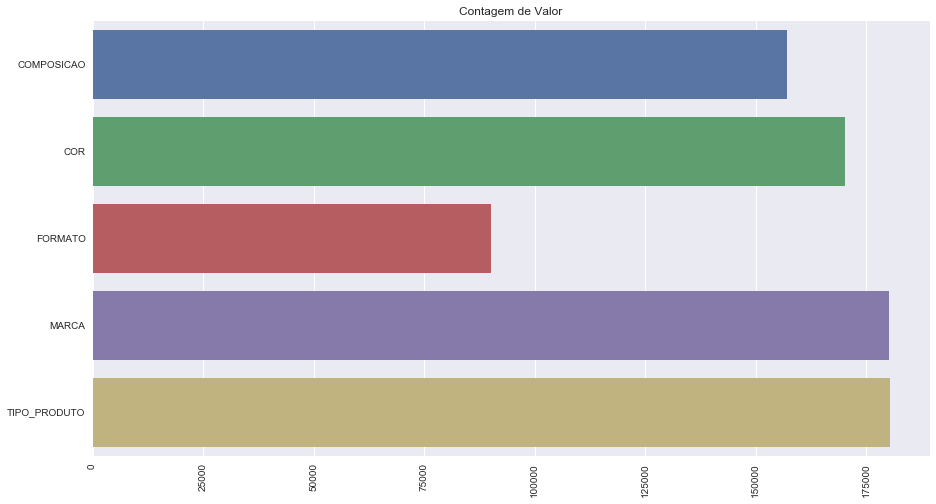

In [30]:
f, axarray = plt.subplots(1,1,figsize=(15,8))
plt.xticks(rotation = 'vertical')
axarray.set_title('Contagem de Valor')

bins = df[cat_cols].count()

sns.barplot(ax=axarray,
            x=bins.values,
            y=bins.index,
            orient='h')

In [31]:
for col in cat_cols:
    modo = df[col].value_counts().index[0]
    df[col] = df[col].fillna(modo)
    
df[cat_cols].describe()

,COMPOSICAO,COR,FORMATO,MARCA,TIPO_PRODUTO
count,180275,180275,180275,180275,180275
unique,3,11,2,15,8
top,ALUMINIO,VERMELHO,REDONDO,TRAMONTINA,PANELA
freq,137515,64184,175353,73245,67390


# 1.1.3.3 Fazer "One Hot Encoding"

Vamos fazer mais uma etapa aqui, para algumas funções vamos precisar de todos os dados numéricos, assim vamos transformar as caraterísticas categóricas para mais caraterísticas binárias. Este tipo de codificação é chamado one hot encoding. Também essa tem um outro benefício, agora temos uma caraterística para cada valor, assim quando nós damos os resultados para o cliente nós podemos dizer qual valor de qual caraterística está impulsionando o alvo.

In [32]:
for col in cat_cols:
    one_hot = pd.get_dummies(df[col])
    for ohc in one_hot.columns.tolist():
        one_hot.rename(columns={ohc:col+': '+ohc}, inplace=True)
    df = pd.concat([df, one_hot], axis=1)
    df.drop(col, 1, inplace=True)

# 1.1.4 Resumo

In [33]:
car_cols = list(set(df.columns.tolist()) - set(['ITEM_ID', 'SESSION_ID', 'INTERESTED']))

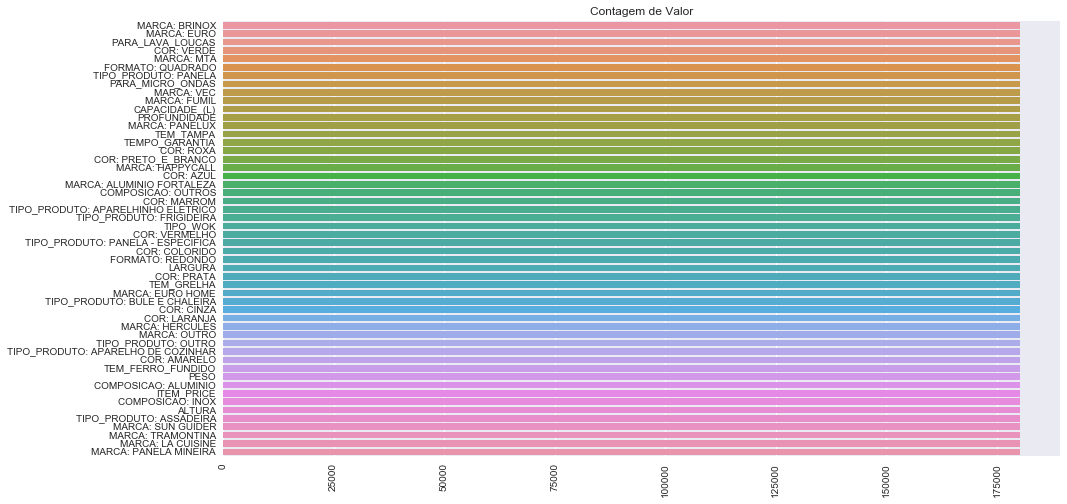

In [34]:
f, axarray = plt.subplots(1,1,figsize=(15,8))
plt.xticks(rotation = 'vertical')
axarray.set_title('Contagem de Valor')

bins = df[car_cols].count()

sns.barplot(ax=axarray,
            x=bins.values,
            y=bins.index,
            orient='h')

In [35]:
df[car_cols].describe()

,MARCA: BRINOX,MARCA: EURO,PARA_LAVA_LOUCAS,COR: VERDE,MARCA: MTA,FORMATO: QUADRADO,TIPO_PRODUTO: PANELA,PARA_MICRO_ONDAS,MARCA: VEC,MARCA: FUMIL,...,PESO,COMPOSICAO: ALUMINIO,ITEM_PRICE,COMPOSICAO: INOX,ALTURA,TIPO_PRODUTO: ASSADEIRA,MARCA: SUN GUIDER,MARCA: TRAMONTINA,MARCA: LA CUISINE,MARCA: PANELA MINEIRA
count,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,...,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000,180275.000000
mean,0.045181,0.024685,0.836522,0.013491,0.010689,0.027303,0.373818,0.027930,0.042868,0.032373,...,311.259118,0.762807,127.831019,0.224984,30.575636,0.096503,0.010928,0.406296,0.178843,0.072267
std,0.207701,0.155162,0.369802,0.115363,0.102835,0.162965,0.483817,0.164771,0.202560,0.176989,...,1277.150101,0.425363,132.216815,0.417573,14.469476,0.295280,0.103963,0.491142,0.383222,0.258931
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.619000,0.000000,0.550000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,160.000000,1.000000,81.311401,0.000000,19.600000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,311.259118,1.000000,107.107222,0.000000,30.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,311.259118,1.000000,139.900000,0.000000,42.700000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,44400.000000,1.000000,2274.990000,1.000000,84.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 1.2 Criar Outras Variáveis

Podemos criar ourtas variáveis usando as caraterísticas que já exitem. Por exemplo podemos criar uma variavel chamado "cor básica" que esta 1 por produtos com cores de "AZUL", "VERDE", etc, e 0 por cores mais complicados como "BERINGELA". Mas aqui não vamos isso.

# 1.3 Explorar os Relacionamentos

In [36]:
len(car_cols)

52

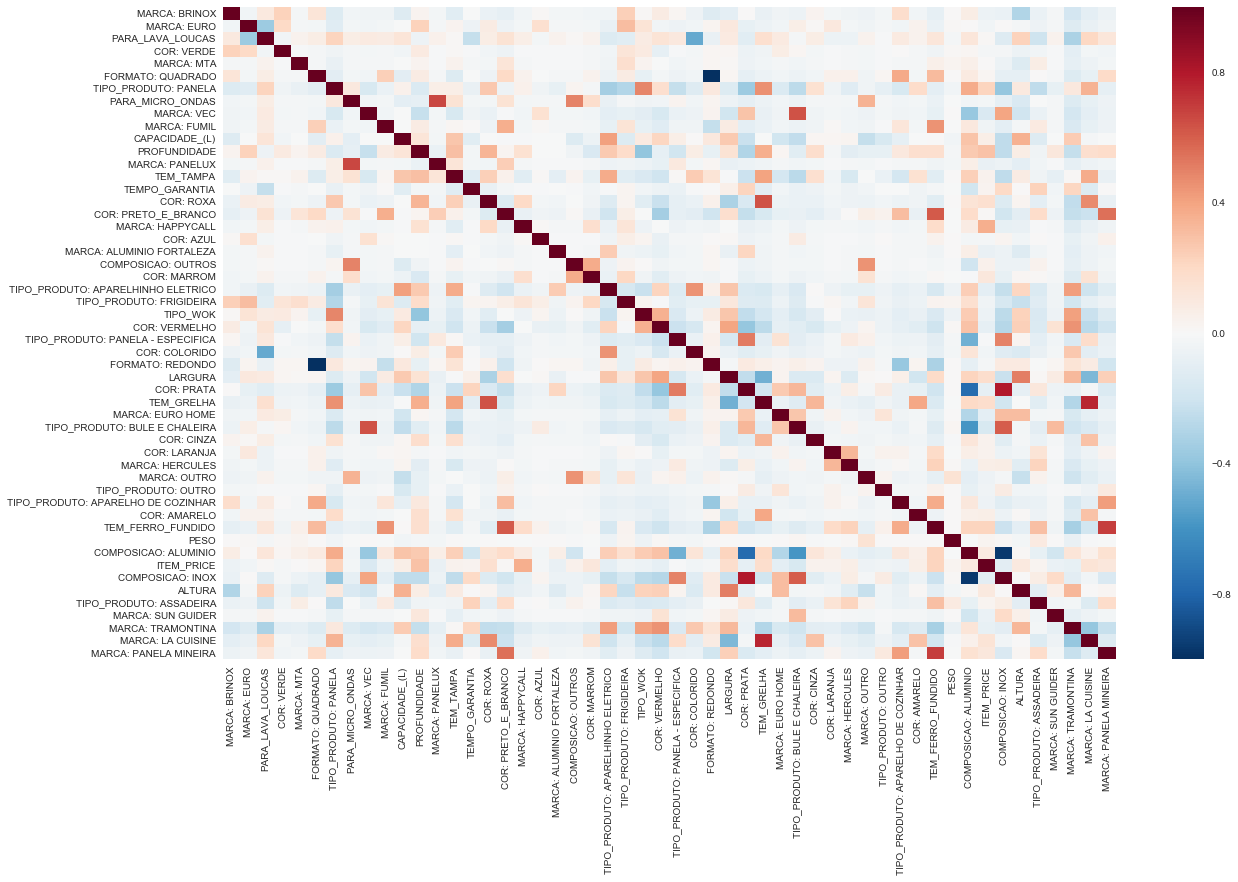

In [37]:
correlations = df[car_cols].corr()
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
sns.heatmap(correlations, ax=ax)

# 1.4 Alvo

In [38]:
print('Numero de registros sem alvo:', len(df[df['INTERESTED'].isnull()]))

Numero de registros sem alvo: 0


In [39]:
df['INTERESTED'].value_counts()/df['INTERESTED'].value_counts().sum()

0.0    0.91387
1.0    0.08613
Name: INTERESTED, dtype: float64

Há 0 registros sem alvo e todos os dados são limpos, assim aqui não precisamos fazer nada, mas depois (Capítulo 2) vamos precisar provar os registros para cima ou para baixo para ter o mesmo número de 1s de 0s

# 2 Criar Modelo

Agora nós podemos criar o modelo, no centro disso é a nossa escolha de classificador. Uma coisa importante de nosso problema é que o cliente quer saber quais caraterísticas têm mais efeito, isso reduz o número de classificadores que nós podemos escolher. Vamos tentar métodos de Tree-Ensemble e regressão.  

In [40]:
X = df[car_cols]
Y = df['INTERESTED']

# 2.1 Normalizar

Vamos normalizar os dados, na verdade isso não é necessário por metodos de Tree Ensemble, mas é importa por regressão que vamos tentar mais tarde. Não normalizamos caraterísticas binárias.

In [41]:
norm = normalize(X[con_cols])
non_con_cols = list(set(X.columns.tolist()) - set(con_cols))
column_names = X[con_cols].columns.tolist()
X = pd.concat([X[non_con_cols],pd.DataFrame(norm, columns=column_names)], axis=1)

# 2.2 Divisão de Treino e Teste

Primeiro vamos dividir o conjunto

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Segundo vamos equilibrar as classes, por isso vamos up-scale a quantidade de 1s, porque há muito 0s e nós não queremos perder 90% de nossos dados. É importante fazermos o up-scaling segundo porque senão parte de nosso conjunto de treino poderia passar dentro do nosso conjunto de teste e faria a nossa precisão errada.

In [43]:
sm = RandomOverSampler()
X_train, Y_train = sm.fit_sample(X_train, Y_train)
X_test, Y_test = sm.fit_sample(X_test, Y_test)

In [44]:
print('Tomanho de conjunto de treino:', len(X_train))
print('Tomanho de conjunto de teste:', len(X_test))

print('Relação de 1s para 0s no treino:', Y_train.sum()/len(Y_train))
print('Relação de 1s para 0s no teste:', Y_train.sum()/len(Y_train))

Tomanho de conjunto de treino: 263722
Tomanho de conjunto de teste: 65774
Relação de 1s para 0s no treino: 0.5
Relação de 1s para 0s no teste: 0.5


# 2.3 Fazer Classificador

# 2.3.1 Métodos de Tree Ensemble 

# 2.3.1.1 Random Forest

Aqui vamos treinar o classificador, e mudar os hyper-parâmetros para melhorar a precisão de cross-validation. Usamos a precisão de cross-validation assim não over-fit para o conjunto de teste.

In [45]:
clf = RandomForestClassifier(n_estimators=10, 
                             max_depth=None,
                             min_samples_split=2, 
                             random_state=0)
scores = cross_val_score(clf, X_train, Y_train)
scores.mean()   

0.80135142157126182

In [46]:
clf = RandomForestClassifier(n_estimators=100, 
                             max_depth=None,
                             min_samples_split=2, 
                             random_state=0)
scores = cross_val_score(clf, X_train, Y_train)
scores.mean()   

0.801707857572727

# 2.3.1.2 Extra Trees

In [47]:
clf = ExtraTreesClassifier(n_estimators=10, 
                           max_depth=None,
                           min_samples_split=2, 
                           random_state=0)
scores = cross_val_score(clf, X_train, Y_train)
scores.mean()   

0.80174956775931772

In [48]:
clf = ExtraTreesClassifier(n_estimators=100, 
                           max_depth=None,
                           min_samples_split=2, 
                           random_state=0)
scores = cross_val_score(clf, X_train, Y_train)
scores.mean()   

0.80177231933486437

# 2.3.2 Regressão Logística

In [49]:
m = LogisticRegression()
m.fit(X_train, Y_train)

print(m.score(X_test, Y_test))

0.568218444978


# 2.4 Escolher o Melhor Classificador

Podemos ver que não há muitas diferenças entre o tipos dos classificadores de árvores, e usando mais árvores não da uma grande melhoria para nós mas o tempo aumenta muito, assim vamos usar Extra-Trees com 10 arvores.

Regressão logística foi muito pior, talvez a fronteira não é singular e assim regressão logística não vai funcionar bem.

In [50]:
clf = ExtraTreesClassifier(n_estimators=10, 
                           max_depth=None,
                           min_samples_split=2, 
                           random_state=0)
clf = clf.fit(X_train, Y_train)

# 2.5 Testar

In [51]:
# Uma função para ajudar com visualização. Escrevi isso antes e estou usando aqui assim tudo é em ingles desculpe.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Precisão: 0.768130264238
Confusion matrix, without normalization
[[23134  9753]
 [ 5498 27389]]


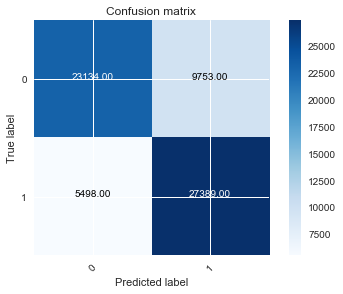

In [52]:
print("Precisão:", clf.score(X_test, Y_test))

Y_pred = clf.predict(X_test)

cfm = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cfm, classes=[0,1])

Podemos ver duas coisas: 
    1. A nossa precisão caiu quando usamos o conjunto de teste, isso é normal particularmente porque usamos up-scaling para obter mais alvos com valor 1. 
    2. Nós prevemos mais erros de tipo 1, assim quando damos para o cliente podemos explicar isso e eles podem ajustar de acordo

# 2.6 Importância das Caraterísticas

# 2.6.1 Importância

Primeiro vamos olhar nas importâncias das caraterísticas, estes volres não dizem se um caraterística é bom pra ter ou não, mas esta análise nos conta onde nos deveriamos colocar o nosso dinheiro fazendo pesquisa. 

In [53]:
importações = pd.DataFrame(np.array([X.columns.tolist(), clf.feature_importances_]).T, columns=['Caraterísticas', 'Importações'])
importações['Importações'] = importações['Importações'].astype(np.float64)
importações = importações.sort_values(by='Importações', ascending=False)
importações[:5]

,Caraterísticas,Importações
48,PESO,0.140281
46,CAPACIDADE_(L),0.138052
51,ITEM_PRICE,0.137705
47,LARGURA,0.133640
50,TEMPO_GARANTIA,0.132591


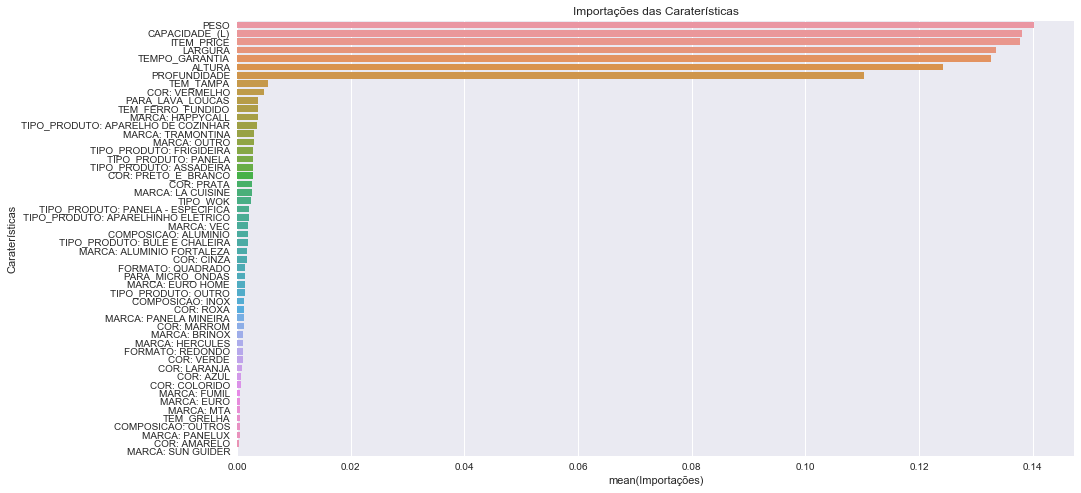

In [54]:
f, axarray = plt.subplots(1,1,figsize=(15,8))
axarray.set_title('Importações das Caraterísticas')

sns.barplot(ax=axarray,
            x=importações['Importações'],
            y=importações['Caraterísticas'])

# 2.6.2 Correlações

Para nos ajudar aprender mais sobre quais caraterísticas são boas e quais são machucando os produtos podemos olhar para as correlções das carateristícas com o alvo. Uma correlação menos de 0 significa que quando o valor dessa caraterística esta mais baixo (ou 0 (não tem) para caraterísticas binarias) pessoas tem menos interesse no producto, para correlações maior do 0 este significa que quando a caraterística esta mais alto (ou 1 (tem) para caraterísticas binarias) pessoas tem mais interesse no producto.

In [55]:
correlações_tudo = df[car_cols+['INTERESTED']].corr()
correlações = correlações_tudo['INTERESTED']
correlações = correlações.drop('INTERESTED', 0)

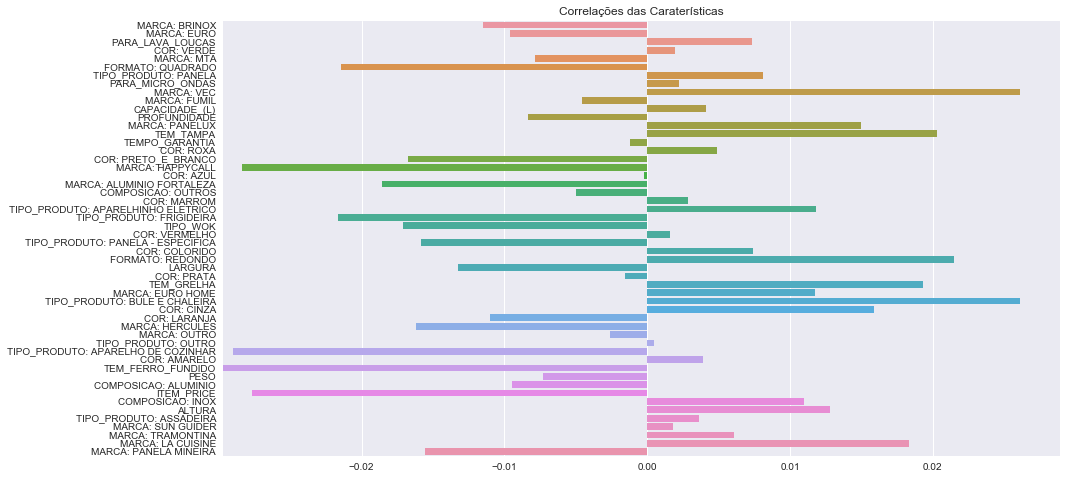

In [56]:
f, axarray = plt.subplots(1,1,figsize=(15,8))
axarray.set_title('Correlações das Caraterísticas')

sns.barplot(ax=axarray,
            x=correlações.values,
            y=correlações.index)

# 2.6.3 Foco

Finalmente vamos combinar as importâncias e correlações dento um valor chamado "foco", este é o valor nos vamos apresentar para o cliente porque o valor tem informação em se uma caraterística é importa, e o que eles precisam fazer com as caraterísticas importas para faz mais produtos interessante.

In [57]:
correlações = pd.DataFrame(correlações).reset_index()
correlações.rename(columns={'index':'Caraterísticas', 'INTERESTED':'Correlações'}, inplace=True)
importações = pd.merge(importações, correlações, how='inner', on='Caraterísticas')
importações['Foco'] = importações['Importações']*importações['Correlações']
importações = importações.sort_values(by='Foco', ascending=False)

In [58]:
importações[:5]

,Caraterísticas,Importações,Correlações,Foco
5,ALTURA,0.124268,0.012796,0.001590
1,CAPACIDADE_(L),0.138052,0.004132,0.000570
7,TEM_TAMPA,0.005511,0.020278,0.000112
24,MARCA: VEC,0.001986,0.026100,0.000052
26,TIPO_PRODUTO: BULE E CHALEIRA,0.001886,0.026130,0.000049


In [59]:
importações.sort_values(by='Foco', ascending=True)[:5]

,Caraterísticas,Importações,Correlações,Foco
2,ITEM_PRICE,0.137705,-0.027669,-0.003810
3,LARGURA,0.133640,-0.013279,-0.001775
0,PESO,0.140281,-0.007270,-0.001020
6,PROFUNDIDADE,0.110361,-0.008374,-0.000924
4,TEMPO_GARANTIA,0.132591,-0.001189,-0.000158


# 2.7 Intuições

 - Podemos ver aqui que o preço de produto é com o maior valor de foco, é claro pra ver que pessoa não gostam gastando tantos dinheiro, mas o que é interessante é que isso é a maior causa de pessoas não tendo interesse nos produtos, assim a coisa mais importa fazer é ficar o preço barato.
 - A mesma importância do preço é a largura dos produtos. As pessoas não gostam de grande largura, mas a correlação é menos aqui, com a mesma importância isso significa que alguns productos com grandes larguras foram de interesse. Acho isso é uma area por mais pesquisa.
 - Peso foi a caraterística mais importa, mas a correlação não é muito forte. Isso significa que peso é bi-modo, por alguns produtos uma grande peso é uma coisa boa, por outros eles precisam ser leves, mas por cada produto o peso seria uma principal preocupação.